In [1]:
# https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/

import pandas as pd
from datetime import datetime, timedelta, date
import numpy as np

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

import math
import matplotlib.pyplot as plt

# Creating functions
All the functions that are used in the fitting and predicting  
**Don't need to run** this unless want to generate new output, use the csv file 'lstm_results.csv' instead  
Or start from "plotting"

In [ ]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()

    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [("var%d(t-%d)" % (j + 1, i)) for j in range(n_vars)]

    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [("var%d(t)" % (j + 1)) for j in range(n_vars)]
        else:
            names += [("var%d(t+%d)" % (j + 1, i)) for j in range(n_vars)]

    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names

    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)

    return agg


# transform series into train and test sets for supervised learning
def prepare_data(series, n_test, n_lag, n_seq):
    # extract raw values
    raw_values = series.values

    # transform data to be stationary
    diff_values = raw_values
    diff_values = diff_values.reshape(len(diff_values), 1)

    # rescale values to -1, 1
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaled_values = scaler.fit_transform(diff_values)
    scaled_values = scaled_values.reshape(len(scaled_values), 1)

    # transform into supervised learning problem X, y
    supervised = series_to_supervised(scaled_values, n_lag, n_seq)
    supervised_values = supervised.values

    # split into train and test sets
    train, test = supervised_values[0:-n_test], supervised_values[-n_test:]
    return scaler, train, test


def fit_lstm(train, n_lag, n_seq, n_batch, nb_epoch, n_neurons):
    # reshape training into [samples, timesteps, features]
    X, y = train[:, 0:n_lag], train[:, n_lag:]

    X = X.reshape(X.shape[0], 1, X.shape[1])

    # design network
    model = Sequential()
    model.add(LSTM(n_neurons, batch_input_shape=(n_batch, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(y.shape[1]))
    model.compile(loss="mean_squared_error", optimizer="adam")

    model.fit(X, y, epochs=nb_epoch, batch_size=n_batch, verbose=2, shuffle=False)

    return model


def forecast_lstm(model, X, n_batch):
    # reshape input pattern to [samples, timesteps, features]
    X = X.reshape(1, 1, len(X))

    # make forecast
    forecast = model.predict(X, batch_size=n_batch)

    # convert to array
    return [x for x in forecast[0, :]]


def make_forecasts(model, n_batch, train, test, n_lag, n_seq, forecast_len):
    forecasts = list()
    print(f'Forecast x of {forecast_len}:', end=" ")
    for i in range(forecast_len):
        X, y = test[i, 0:n_lag], test[i, n_lag:]
        # make forecast
        forecast = forecast_lstm(model, X, n_batch)
        # store the forecast
        forecasts.append(forecast)

        # Printing current status in hundreds
        step = i % 100
        if step == 0:
            print(i, end=" ")

    return forecasts


def inverse_transform(series, forecasts, scaler):
    inverted = list()
    for i in range(len(forecasts)):

        # create array from forecast
        forecast = np.array(forecasts[i])
        forecast = forecast.reshape(1, len(forecast))

        # invert scaling
        inv_scale = scaler.inverse_transform(forecast)
        inv_scale = inv_scale[0, :]

        inverted.append(inv_scale)

    return inverted

# Fitting and predicting
Outputs a matrix with 63 forecasts for every t 1000 periods ahead  
**Don't need to run** this unless want to generate new output, use the csv file 'lstm_results.csv' instead
Or start from "plotting"

In [ ]:
# load dataset
logreturns = "data/final.csv"
series = pd.read_csv(logreturns, usecols=["Exchange.Date", "logreturns"], header=0, index_col=0, squeeze=True)

# configure
n_lag = 1 # same as ARMA-GARCH
n_seq = 63  #  number of periods forecast
test_share = 0.25
n_test = int(len(series) * test_share)
n_epochs = 5
n_batch = 1
n_neurons = 50
forecast_len = 1000

print("Preparing data...")
scaler, train, test = prepare_data(series, n_test, n_lag, n_seq)

print("Fitting model...")
model = fit_lstm(train, n_lag, n_seq, n_batch, n_epochs, n_neurons)

print("Making forecasts...")
forecasts = make_forecasts(model, n_batch, train, test, n_lag, n_seq, forecast_len)

print("\nInverting forecasts...")
forecasts = inverse_transform(series, forecasts, scaler)
print("Done!")

# Generating CSV
_**Not recommended to run this chunk**, unless the above "fitting and predicting" has been run. Use the csv-file instead. That way, we can be sure to get the same results repeatedly._  
Or start from "plotting"

In [ ]:
# Creating df that is as alike arch_evaluate as possible
original_df = pd.read_csv("data/final.csv", usecols=["Exchange.Date", "logreturns", "Close"])
cross_df = pd.DataFrame(columns=['time', 'Close', 'forecast'])

forecast_len = 1000
for i in range(forecast_len):
    train_size_cv = int(len(original_df) * 0.75) + i
    train_cv = original_df[:train_size_cv]
    last_train = train_cv['Close'].values[-1]
    test_cv = original_df[train_size_cv : len(original_df)]

    price_forecasts = np.exp(np.cumsum(forecasts[i]) + math.log(last_train))

    for j, forecast in enumerate(price_forecasts):
        cross_df = cross_df.append({
            'time': i+1,
            'forecast': forecast,
            'Close': test_cv['Close'].values[j]
        }, ignore_index=True)

    step = i % 100
    if step == 0:
        print(i, end=" ")

print('done!')
cross_df.to_csv('data/lstm_results.csv', index=False)

# Plotting

## Creating a plot df for t=1


In [2]:
# Importing original df
original_df = pd.read_csv("data/final.csv", usecols=["Exchange.Date", "logreturns", "Close"])

In [3]:
# configurations (same as in predicting)

n_lag = 1 # same as ARMA-GARCH
n_seq = 63  #  number of periods forecast
test_share = 0.25
n_test = int(len(original_df) * test_share)
n_epochs = 5
n_batch = 1
n_neurons = 50
forecast_len = 1000

In [4]:
# Setting as date
original_df['Exchange.Date'] = original_df['Exchange.Date'].apply(lambda x: date(1900, 1, 1) + timedelta(int(x)))
original_df.index = original_df['Exchange.Date']

In [5]:
# Assigning all rows in train df (before forecast) to closing value
# This is because this column cannot be empty (and we have no forecasts since it's training data)

train_df = original_df[:-n_test].copy()
train_df["forecast"] = train_df["Close"]

In [6]:
# Transforming logreturns back to price

lstm_cross_df = pd.read_csv('data/lstm_results.csv')
price_forecasts = lstm_cross_df[:63]['forecast']

In [7]:
# Creating a separate dataframe only for forecasts

forecast_df = pd.DataFrame(columns=["Exchange.Date", "Close", "logreturns", "forecast"])
forecast_df["Close"] = original_df["Close"].values[-n_test : -n_test + n_seq]
forecast_df["logreturns"] = original_df["logreturns"].values[-n_test : -n_test + n_seq]
forecast_df["forecast"] = price_forecasts
forecast_df["Exchange.Date"] = forecast_df.index.map(lambda x: date(2016, 8, 1) + timedelta(int(x)))

forecast_df.index = forecast_df["Exchange.Date"]

In [8]:
# Merging train and forecast dataframe

merged_df = train_df.append(forecast_df, ignore_index=True)

## Generating plot

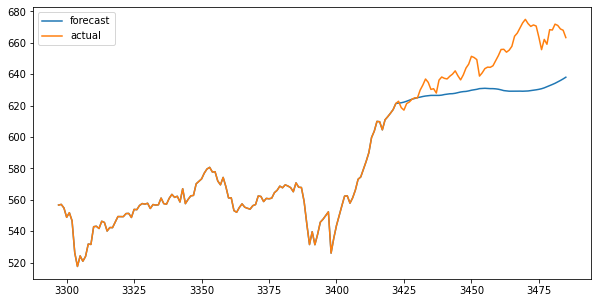

In [9]:
plot_df = merged_df[-n_seq - (n_seq * 2) :] # -n_seq controls how many to show before the forecast (blue) line
plt.figure(figsize=(10, 5))
plt.plot(plot_df["forecast"], label="forecast")
plt.plot(plot_df["Close"], label="actual")
plt.legend()

# Cross-validating 2.0
The previous one was messy, this is (hopefully) better. And more like arch_evaluate

## Reading CSV and assigning columns
_Run this chunk instead, it reads the csv from the chunk above_

In [10]:
# Reading lstm_cross_val.csv
lstm_cross_df = pd.read_csv('data/lstm_results.csv')

In [11]:
# adding first row of data based on last row of test data (manually input bcuz lazy)

new_data = []
new_data.insert(0, {'time':0, 'Close': 621.38, 'forecast': 621.38})
lstm_cross_df = pd.concat([pd.DataFrame(new_data), lstm_cross_df], ignore_index=True)

In [12]:
# creating error and up columns 

lstm_cross_df['error'] = lstm_cross_df['forecast'] - lstm_cross_df['Close']
lstm_cross_df['abs_error'] = np.abs(lstm_cross_df['forecast'] - lstm_cross_df['Close'])
lstm_cross_df['actual_up'] = lstm_cross_df['Close'].diff(1) > 0
lstm_cross_df['forecast_up'] = lstm_cross_df['forecast'].diff(1) > 0

In [13]:
# creating confusion column

def confusion(actual, forecast):
    if (actual and forecast):
        return 'TP'
    
    if (actual and not forecast):
        return 'FN'
    
    if (not actual and forecast):
        return 'FP'
    
    if (not actual and not forecast):
        return 'TN'
    
    return False

lstm_cross_df['confusion'] = lstm_cross_df.apply(lambda x: confusion(x['actual_up'], x['forecast_up']), axis=1)

In [14]:
# Displaying the first 3 rows
# Note that the first row is equal to the last one in the training data

lstm_cross_df.head(3)

,time,Close,forecast,error,abs_error,actual_up,forecast_up,confusion
0,0.0,621.38,621.380000,0.000000,0.000000,False,False,TN
1,1.0,622.77,621.587524,-1.182476,1.182476,True,True,TP
2,1.0,618.70,621.805115,3.105115,3.105115,False,True,FP


## Creating cross evaluation scores for each of the 1000 periods

In [15]:
# Creating a dataframe with all the columns needed

cross_df = pd.DataFrame(columns=[
    "mape_1", 
    "mape_3",
    "mape_5",
    "mape_21",
    "mape_63",
    "rmse_1",
    "rmse_3",
    "rmse_5",
    "rmse_21",
    "rmse_63",
    'precision_1',
    'precision_3',
    'precision_5',
    'precision_21',
    'precision_63',
    'recall_1',
    'recall_3',
    'recall_5',
    'recall_21',
    'recall_63',
    'fscore_1',
    'fscore_3',
    'fscore_5',
    'fscore_21',
    'fscore_63',
])

In [16]:
# Cross evaluation function

def cross_evaluate(df, n_periods):
    df = df[ : n_periods]
    mape = ((df["abs_error"] / df["Close"]).sum() / n_periods) * 100
    rmse = math.sqrt(pow(df["error"].sum(), 2) / n_periods)

    tp = len(df[df['confusion'] == 'TP'])
    fp = len(df[df['confusion'] == 'FP'])
    fn = len(df[df['confusion'] == 'FN'])

    precision = tp / (tp + fp) if (tp + fp) > 0 else 0 # if else för att undvika division by zero errror
    recall = tp / (tp + fn) if (tp + fn > 0) else 0
    fscore = (2*precision*recall)/(precision+recall) if (precision + recall > 0) else 0

    return mape, rmse, precision, recall, fscore

In [17]:
# For every 63 forecasts of the 1000 periods forecasted, create scores

forecast_len = 1000
for i in range(forecast_len):
    cross_merged_df = lstm_cross_df[lstm_cross_df['time'] == i+1] # since indexing starts at 1
    one = cross_evaluate(cross_merged_df, 1)
    three = cross_evaluate(cross_merged_df, 3)
    five = cross_evaluate(cross_merged_df, 5)
    twentyone = cross_evaluate(cross_merged_df, 21)
    sixtythree = cross_evaluate(cross_merged_df, 63)

    cross_df = cross_df.append({
        'mape_1': one[0],
        'mape_3': three[0],
        'mape_5': five[0],
        'mape_21': twentyone[0],
        'mape_63': sixtythree[0],
        'rmse_1': one[1],
        'rmse_3': three[1],
        'rmse_5': five[1],
        'rmse_21': twentyone[1],
        'rmse_63': sixtythree[1],
        'precision_1': one[2],
        'precision_3': three[2],
        'precision_5': five[2],
        'precision_21': twentyone[2],
        'precision_63': sixtythree[2],
        'recall_1': one[3],
        'recall_3': three[3],
        'recall_5': five[3],
        'recall_21': twentyone[3],
        'recall_63': sixtythree[3],
        'fscore_1': one[4],
        'fscore_3': three[4],
        'fscore_5': five[4],
        'fscore_21': twentyone[4],
        'fscore_63': sixtythree[4],
    }, ignore_index=True)

    step = i % 100
    if step == 0:
        print(i, end=" ")

print('done!')

0 100 200 300 400 500 600 700 800 900 done!


In [18]:
# Only the results when t=1

cross_df[:1].transpose()

,0
mape_1,0.189874
mape_3,0.505772
mape_5,0.388258
mape_21,0.887633
mape_63,2.925779
rmse_1,1.182476
rmse_3,4.051475
rmse_5,4.317093
rmse_21,20.974583
rmse_63,150.206292


## Description of RMSE and MAPE

In [ ]:
#cross_df.iloc[:, :10].describe()

## Description of precision, recall and fscore

In [ ]:
#cross_df.iloc[:, 10:].describe()

## Confidence intervals for RMSE, MAPE, precision, recall and fscore

In [19]:
n = cross_df.count()[0]
mean = cross_df.mean()
upper = cross_df.mean() + 1.96 * cross_df.std() / math.sqrt(n)
lower = cross_df.mean() - 1.96 * cross_df.std() / math.sqrt(n)

ci_df = pd.DataFrame(columns=['measure', 'mean', 'lower', 'upper'])

for i in range(25):
    ci_df = ci_df.append({
        'measure': cross_df.columns[i],
        'mean': mean[i],
        'lower': lower[i],
        'upper': upper[i]
    }, ignore_index=True)

ci_df

,measure,mean,lower,upper
0,mape_1,0.613545,0.563758,0.663332
1,mape_3,0.926777,0.860884,0.992671
2,mape_5,1.190527,1.103570,1.277484
3,mape_21,2.749462,2.549759,2.949164
4,mape_63,5.403585,5.145710,5.661461
5,rmse_1,4.965353,4.581066,5.349639
6,rmse_3,12.155956,11.255011,13.056901
7,rmse_5,19.816034,18.297171,21.334897
8,rmse_21,92.261077,85.253308,99.268845
9,rmse_63,322.016801,304.707724,339.325877
